In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-image-dataset/Y.npy
/kaggle/input/breast-cancer-image-dataset/X.npy


In [128]:
# basic package
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import optuna

#
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## diacord Warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

In [36]:
def load_npdata(file_path):
    data = np.load(file_path)
    return data

In [43]:
X = load_npdata('/kaggle/input/breast-cancer-image-dataset/X.npy')
Y = load_npdata('/kaggle/input/breast-cancer-image-dataset/Y.npy')

In [38]:
# # 截取片段用于测试CV&parameter tuning
# np.save('X_subset.npy', X[2400:3200,])
# np.save('Y_subset.npy', Y[2400:3200,])

# X_subset = X[2400:3200,].copy()
# y_subset = Y[2400:3200,].copy()

In [10]:
X.shape 
#X_subset.shape

(5547, 50, 50, 3)

# EDA

In [12]:
# plotly 绘图 & 运行较慢
red_channel = X_subset[:,:,:,0].flatten()   # 红色通道
green_channel = X_subset[:,:,:,1].flatten() # 绿色通道
blue_channel = X_subset[:,:,:,2].flatten()  # 蓝色通道

# 创建直方图
fig = go.Figure()
fig.add_trace(go.Histogram(x=red_channel, nbinsx=256, name='Red Channel', marker_color='red', opacity=0.6))
fig.add_trace(go.Histogram(x=green_channel, nbinsx=256, name='Green Channel', marker_color='green', opacity=0.6))
fig.add_trace(go.Histogram(x=blue_channel, nbinsx=256, name='Blue Channel', marker_color='blue', opacity=0.6))

# 更新布局
fig.update_layout(
    title_text='Pixel Intensity Distribution for Each Color Channel',
    xaxis_title_text='Pixel Intensity',
    yaxis_title_text='Frequency',
    bargap=0.2,
    barmode='overlay'
)

# 显示图表
fig.show()

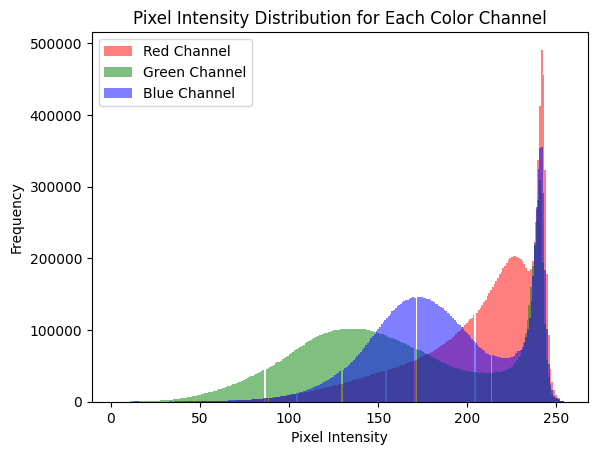

In [44]:
def Pixel_Intensity_plot(X):
    red_channel = X[:,:,:,0].flatten()   
    green_channel = X[:,:,:,1].flatten() 
    blue_channel = X[:,:,:,2].flatten()  

    
    bins = 256
    alpha = 0.5

    
    plt.hist(red_channel, bins=bins, color='red', alpha=alpha, label='Red Channel')
    plt.hist(green_channel, bins=bins, color='green', alpha=alpha, label='Green Channel')
    plt.hist(blue_channel, bins=bins, color='blue', alpha=alpha, label='Blue Channel')

    
    plt.title('Pixel Intensity Distribution for Each Color Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
Pixel_Intensity_plot(X)

## Data_Scaling

In [7]:
def data_Scaling(X):
    X = X.copy()
    num_images, height, width, channels = X.shape
    X_reshaped = X.reshape(num_images, -1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_images, height, width, channels)
    return X_scaled

In [45]:
X = data_Scaling(X)
Y = Y

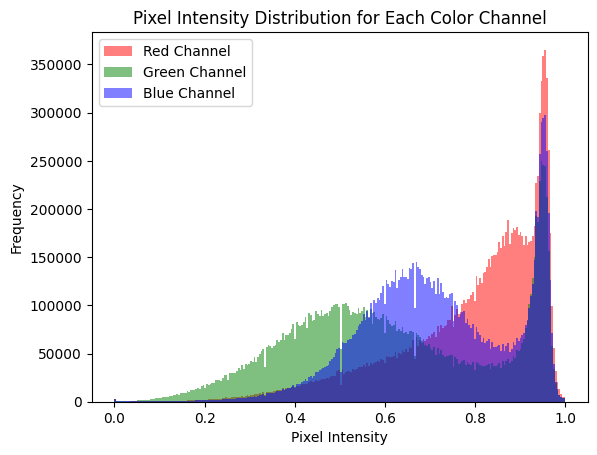

In [42]:
Pixel_Intensity_plot(X)

### Comparison of IDC and Non-IDC Sample Counts

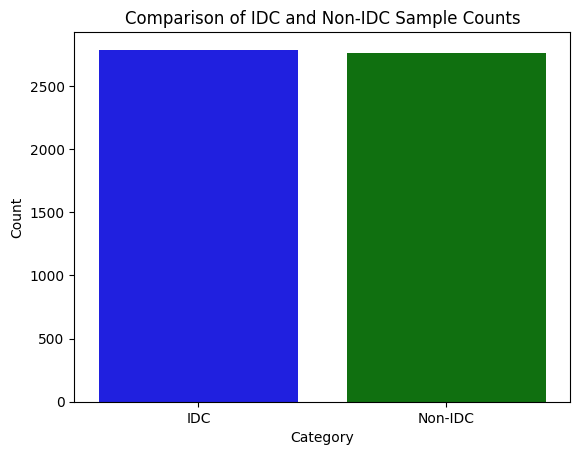

In [17]:
# 计算 IDC 和 Non-IDC 的数量
IDC_count = Y.sum()
Non_IDC_count = len(Y) - IDC_count

# 数据
categories = ['IDC', 'Non-IDC']
counts = [IDC_count, Non_IDC_count]

# 创建一个 DataFrame
import pandas as pd
data = pd.DataFrame({'Category': categories, 'Count': counts})

# 绘制条形图
sns.barplot(x='Category', y='Count', data=data, palette=['blue', 'green'])

# 添加标题
plt.title('Comparison of IDC and Non-IDC Sample Counts')

# 显示图表
plt.show()

# Logistic/SVM/Random forest/LGBM Classification

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (4714, 7500)
Testing Data Shape: (833, 7500)


### Logistic

CPU times: user 15.3 s, sys: 2.36 s, total: 17.6 s
Wall time: 5.08 s
CV_scores [0.75788288 0.75788288 0.73055242 0.7102593  0.72491545]


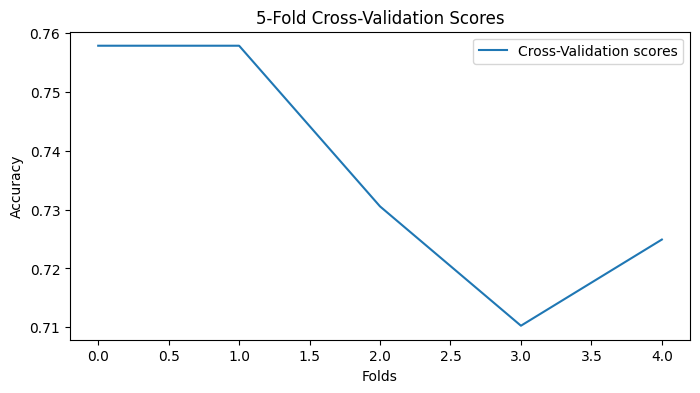

Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best cross-validation score: 0.74


In [94]:
# 创建逻辑回归模型
logreg = LogisticRegression(max_iter=20)

# 进行 K 折交叉验证
%time kfold_scores = cross_val_score(logreg, X_train, Y_train, cv=5)

# 可视化输出分数
print('CV_scores',kfold_scores)
plt.figure(figsize=(8, 4))
plt.plot(kfold_scores, label='Cross-Validation scores')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.legend()
plt.show()

# 超参数优化
param_grid = {'C': [0.01,0.5, 0.1, 1], 'penalty': ['none', 'l2']}
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(X_train, Y_train)

# 打印最优参数和最优分数
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

In [95]:
best_logreg = LogisticRegression(**grid.best_params_, max_iter=50)
best_logreg.fit(X_train, Y_train)
y_pred_logreg = best_logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(Y_test, y_pred_logreg))
print(classification_report(Y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.7756756756756756
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       537
           1       0.82      0.72      0.77       573

    accuracy                           0.78      1110
   macro avg       0.78      0.78      0.78      1110
weighted avg       0.78      0.78      0.78      1110



### optuna + RF

In [ ]:
def objective(trial):
    
    # 设置随机森林的超参数空间
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2,20)
    
    # 实例化随机森林分类器
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=2024
    )
    
    # 在训练集上训练模型
    clf.fit(X_train, Y_train)

    # 执行K折交叉验证并收集每一轮的分数
    scores = cross_val_score(clf, X_train, Y_train, n_jobs=-1, cv=3)
    trial.set_user_attr("cv_scores", scores.tolist())  

    # 返回平均分数
    return scores.mean()

# 创建optuna的study对象
study = optuna.create_study(direction="minimize")

# 运行优化过程，指定优化的次数
study.optimize(objective, n_trials=20)

# 收集每次试验的分数
all_scores = [trial.user_attrs["cv_scores"] for trial in study.trials]

# 最佳参数
best_params = study.best_params

print("Best hyperparameters:", study.best_params)
print('Best Log Loss:', study.best_value) 

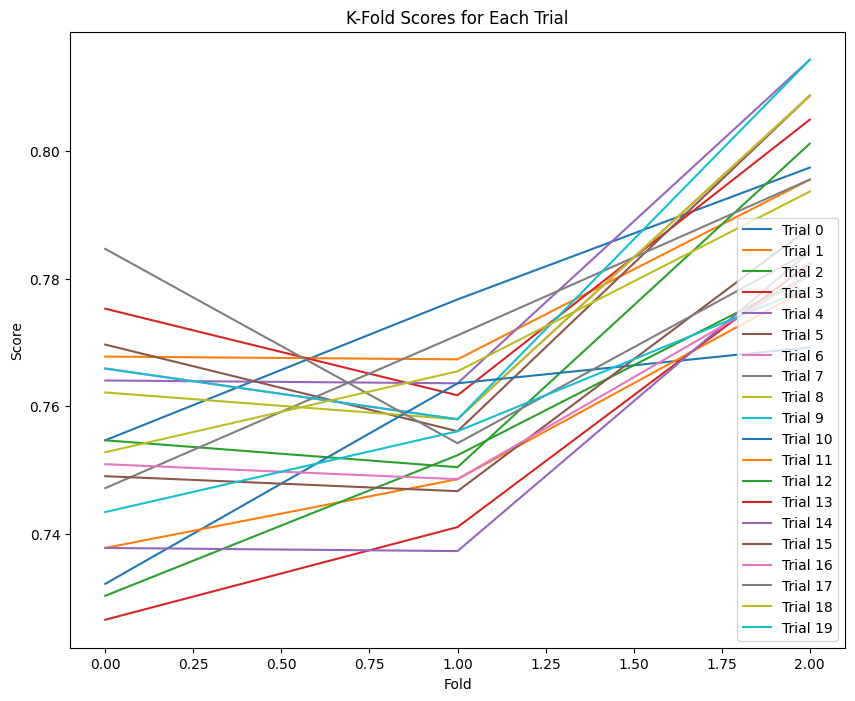

In [44]:
# 绘制每轮的K折交叉验证分数
plt.figure(figsize = (10,8))
for index, trial_scores in enumerate(all_scores):
    plt.plot(trial_scores, label=f'Trial {index}')

plt.title('K-Fold Scores for Each Trial')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

Random Forest Accuracy: 0.755
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       192
           1       0.79      0.73      0.76       208

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400



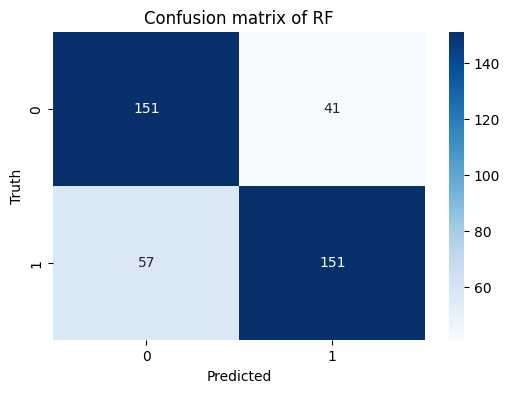

In [45]:
best_rf = RandomForestClassifier(**best_params)

best_rf.fit(X_train, Y_train)

y_pred_rf = best_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))


cm = confusion_matrix(Y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',cmap = 'Blues')
plt.title('Confusion matrix of RF')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### SVM

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  13.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  12.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  13.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  13.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  12.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  11.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  11.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END ...........................C=1, gamma=1,

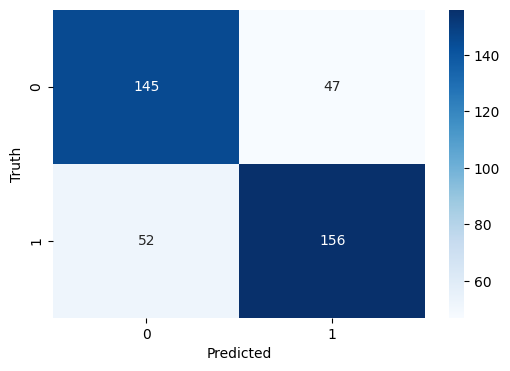

In [58]:
# 定义超参数网格
param_grid = {
    'C': [0.1, 1, 5,10],
    'gamma': [1, 0.1, 0.01 ],
    'kernel': ['rbf']
}

# 创建SVM模型
svc = SVC()

# 使用网格搜索
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=2)

# 在训练集上训练模型
grid_search.fit(X_train, Y_train)

# 打印最佳参数
print(f"Best Parameters: {grid_search.best_params_}")

# 使用最佳参数的模型进行预测
y_pred = grid_search.predict(X_test)

# 评估模型
print(classification_report(Y_test, y_pred))

# 混淆矩阵
cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


# 2.特征工程&拟合模型

尝试性:灰度化,直方图均衡化，高斯平滑

In [9]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        # 将图像数据标准化到 0-255 范围
        img_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img_normalized = img_normalized.astype(np.uint8)

        # 灰度化
        gray = cv2.cvtColor(img_normalized, cv2.COLOR_RGB2GRAY)
        
        # 直方图均衡化
        equalized = cv2.equalizeHist(gray)
        
        smoothed = cv2.GaussianBlur(equalized, (3, 3), 0)

        processed_images.append(smoothed)

    return np.array(processed_images)

# 假设 X_subset 是您的子集图像数据
x_processed = preprocess_images(X)

In [10]:
def data_Scaling1(X):
    X = X.copy()
    num_images, height, width = X.shape
    X_reshaped = X.reshape(num_images, -1)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_images, height, width)
    return X_scaled

x_processed = data_Scaling1(x_processed)
# 检查处理后的数据
print(x_processed.shape)

(5547, 50, 50)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_processed, Y, test_size=0.2)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print("Training Data Shape:", x_train.shape)
print("Testing Data Shape:", x_test.shape)

Training Data Shape: (4437, 2500)
Testing Data Shape: (1110, 2500)


### Logistic 回归

CPU times: user 2.5 s, sys: 754 ms, total: 3.26 s
Wall time: 943 ms
CV_scores [0.61711712 0.61677187 0.63029757 0.61406673]


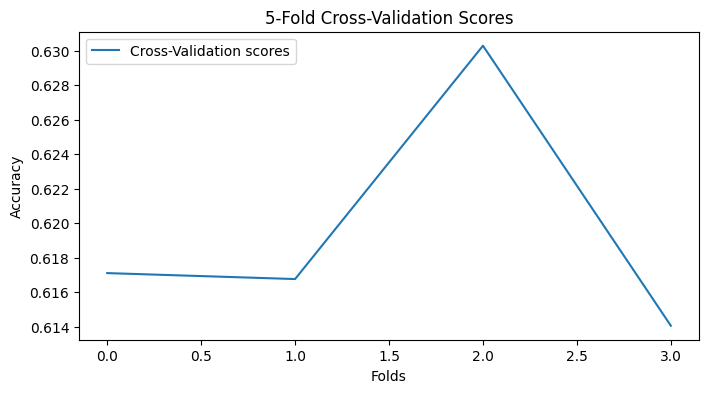

Best parameters: {'C': 0.05, 'penalty': 'l2'}
Best cross-validation score: 0.62


In [17]:
# 创建逻辑回归模型
logreg = LogisticRegression(max_iter=20)

# 进行 K 折交叉验证
%time kfold_scores = cross_val_score(logreg, x_train, y_train, cv=4)

# 可视化输出分数
print('CV_scores',kfold_scores)
plt.figure(figsize=(8, 4))
plt.plot(kfold_scores, label='Cross-Validation scores')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation Scores')
plt.legend()
plt.show()

# 超参数优化
param_grid = {'C': [0.05,0.5, 0.2,], 'penalty': ['none', 'l2']}
grid = GridSearchCV(logreg, param_grid, cv=5)
grid.fit(x_train, y_train)

# 打印最优参数和最优分数
print("Best parameters:", grid.best_params_)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

In [20]:
best_logreg1 = LogisticRegression(**grid.best_params_, max_iter=50)
best_logreg1.fit(x_train, y_train)
y_pred_logreg1 = best_logreg1.predict(x_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg1))
print(classification_report(y_test, y_pred_logreg1))

Logistic Regression Accuracy: 0.5945945945945946
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       555
           1       0.59      0.61      0.60       555

    accuracy                           0.59      1110
   macro avg       0.59      0.59      0.59      1110
weighted avg       0.59      0.59      0.59      1110



### Optuna+RF

In [54]:
def objective(trial):
    
    # 设置随机森林的超参数空间
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 2,20)
    
    # 实例化随机森林分类器
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=2024
    )
    
    # 在训练集上训练模型
    clf.fit(x_train, y_train)

    # 执行K折交叉验证并收集每一轮的分数
    scores = cross_val_score(clf, x_train, y_train, n_jobs=-1, cv=3)
    trial.set_user_attr("cv_scores", scores.tolist())  

    # 返回平均分数
    return scores.mean()

# 创建optuna的study对象
study = optuna.create_study(direction="minimize")

# 运行优化过程，指定优化的次数
study.optimize(objective, n_trials=20)

# 收集每次试验的分数
all_scores = [trial.user_attrs["cv_scores"] for trial in study.trials]

# 最佳参数
best_params = study.best_params

print("Best hyperparameters:", study.best_params)
print('Best Log Loss:', study.best_value) 



[I 2024-01-25 03:41:06,690] A new study created in memory with name: no-name-fba39b38-7f7a-43d0-ba6d-d110764727b5
[I 2024-01-25 03:41:16,071] Trial 0 finished with value: 0.673742718412491 and parameters: {'n_estimators': 86, 'max_depth': 14}. Best is trial 0 with value: 0.673742718412491.
[I 2024-01-25 03:41:18,658] Trial 1 finished with value: 0.6549915326292415 and parameters: {'n_estimators': 93, 'max_depth': 2}. Best is trial 1 with value: 0.6549915326292415.
[I 2024-01-25 03:41:19,934] Trial 2 finished with value: 0.6606177081649814 and parameters: {'n_estimators': 35, 'max_depth': 3}. Best is trial 1 with value: 0.6549915326292415.
[I 2024-01-25 03:41:27,015] Trial 3 finished with value: 0.6725036481134041 and parameters: {'n_estimators': 56, 'max_depth': 20}. Best is trial 1 with value: 0.6549915326292415.
[I 2024-01-25 03:41:34,897] Trial 4 finished with value: 0.6800083385449239 and parameters: {'n_estimators': 84, 'max_depth': 10}. Best is trial 1 with value: 0.6549915326292

Best hyperparameters: {'n_estimators': 10, 'max_depth': 13}
Best Log Loss: 0.6224993148807892


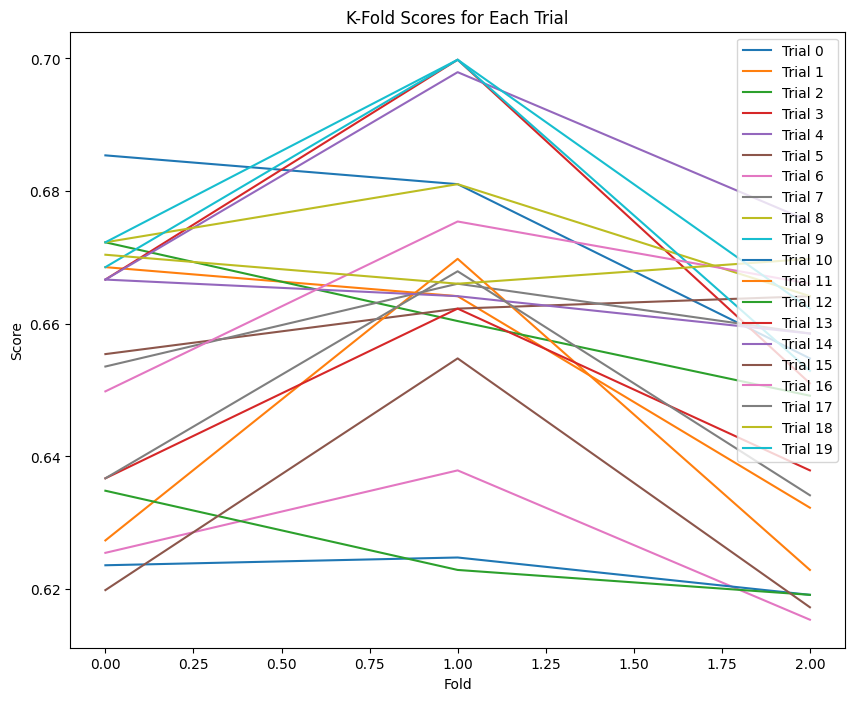

Random Forest Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       193
           1       0.65      0.75      0.70       207

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400



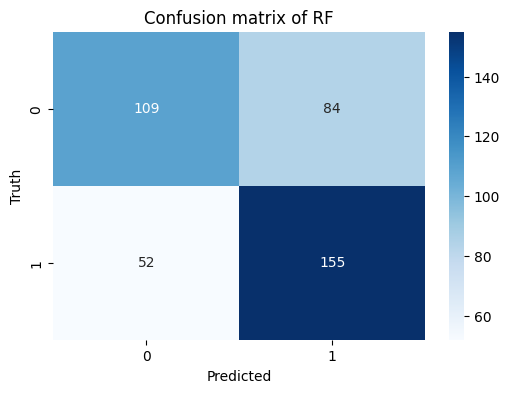

In [56]:
# 绘制每轮的K折交叉验证分数
plt.figure(figsize = (10,8))
for index, trial_scores in enumerate(all_scores):
    plt.plot(trial_scores, label=f'Trial {index}')

plt.title('K-Fold Scores for Each Trial')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.show()

best_rf1 = RandomForestClassifier(**best_params)

best_rf1.fit(x_train, y_train)

y_pred_rf1 = best_rf1.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf1))
print(classification_report(y_test, y_pred_rf1))


cm = confusion_matrix(y_test, y_pred_rf1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',cmap = 'Blues')
plt.title('Confusion matrix of RF')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### SVM model

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  27.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  27.8s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=  25.0s
[CV] END ......................C=0.1, gamma=0.01,

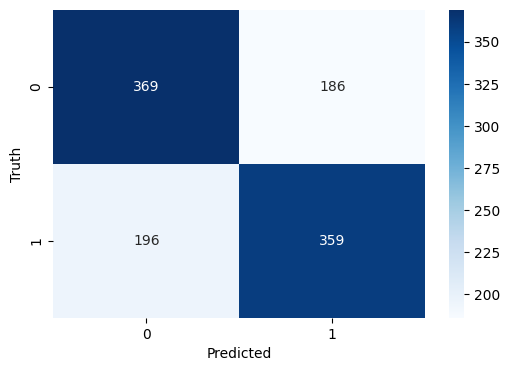

In [12]:
# 定义超参数网格
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

# 创建SVM模型
svc = SVC()

# 使用网格搜索
grid_search = GridSearchCV(svc, param_grid, refit=True, verbose=2,cv=3)

# 在训练集上训练模型
grid_search.fit(x_train, y_train)

# 打印最佳参数
print(f"Best Parameters: {grid_search.best_params_}")

              precision    recall  f1-score   support

           0       0.65      0.66      0.66       555
           1       0.66      0.65      0.65       555

    accuracy                           0.66      1110
   macro avg       0.66      0.66      0.66      1110
weighted avg       0.66      0.66      0.66      1110



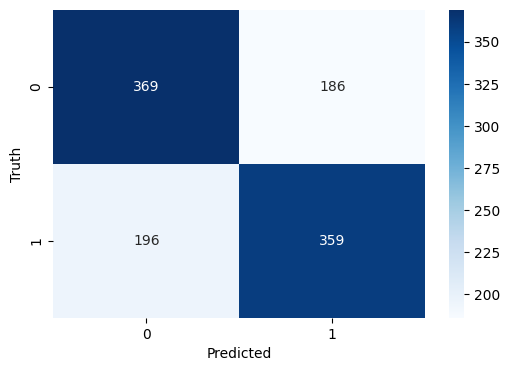

In [16]:
# 使用最佳参数的模型进行预测
y_pred1 = grid_search.predict(x_test)

# 评估模型
print(classification_report(y_test, y_pred1))

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# 3.Keras CNN classification

In [70]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y, test_size=0.2)
Y_train1 = to_categorical(Y_train1)
Y_test1 = to_categorical(Y_test1)
X_train.shape

(4714, 2)

In [75]:
#设置早停 waiting epochs = 5
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
#layer 1
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
#layer 2
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
#layer 3
model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
#layer 4
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
#layer 5
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
#output layer
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

#complie model
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_209 (Conv2D)         (None, 50, 50, 32)        896       
                                                                 
 batch_normalization_212 (B  (None, 50, 50, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_210 (Conv2D)         (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 25, 25, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_213 (B  (None, 25, 25, 32)        128       
 atchNormalization)                                              
                                                      

In [86]:
# 定义ModelCheckpoint回调
checkpoint = ModelCheckpoint('best_model.h5',  
                             monitor='val_loss',  
                             verbose=1,
                             save_best_only=True,  # 只保存在验证集上性能最好的模型
                             mode='min')  


%time history = model.fit(X_train1, Y_train1, validation_data = (X_test1, Y_test1), epochs = 36, batch_size = 64,callbacks=[checkpoint])

Epoch 1/36
34/35 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9936
Epoch 1: val_loss improved from inf to 1.25335, saving model to best_model.h5
35/35 [==============================] - 2s 47ms/step - loss: 0.0200 - accuracy: 0.9935 - val_loss: 1.2533 - val_accuracy: 0.7748
Epoch 2/36
35/35 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9937
Epoch 2: val_loss did not improve from 1.25335
35/35 [==============================] - 1s 42ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 1.2563 - val_accuracy: 0.7730
Epoch 3/36
35/35 [==============================] - ETA: 0s - loss: 0.0225 - accuracy: 0.9932
Epoch 3: val_loss improved from 1.25335 to 1.23669, saving model to best_model.h5
35/35 [==============================] - 2s 46ms/step - loss: 0.0225 - accuracy: 0.9932 - val_loss: 1.2367 - val_accuracy: 0.7649
Epoch 4/36
35/35 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9928
Epoch 4: val_loss did not i

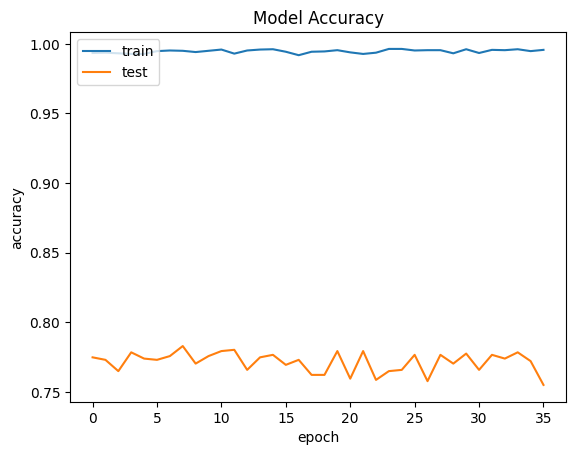

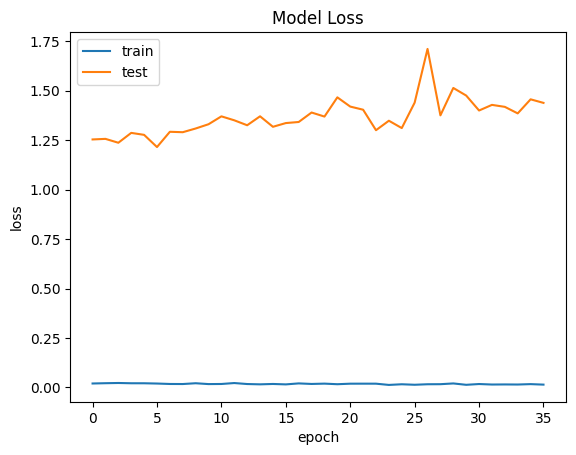

In [88]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

35/35 [==============================] - 0s 4ms/step
Accuracy: 0.772972972972973


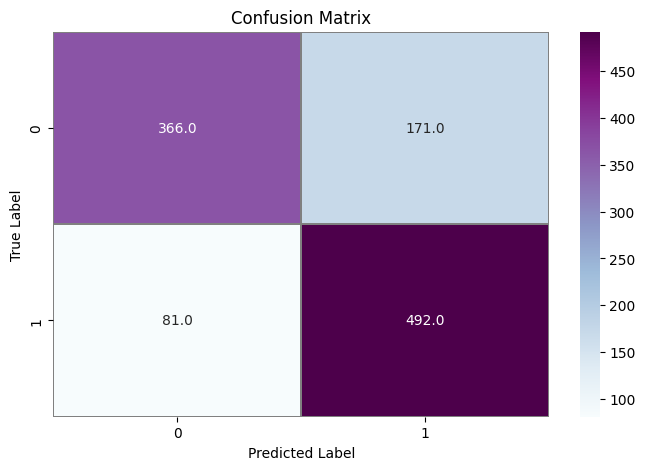

In [90]:
# 加载模型
model = load_model('best_model.h5')
Y_pred = model.predict(X_test1)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_test1,axis = 1) 

accuracy = accuracy_score(Y_true, Y_pred_classes)
print("Accuracy:", accuracy)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 4.迁移学习 based on Efficient Net or resnet

In [96]:
# !pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 925.5 kB/s eta 0:00:00a 0:00:01


In [103]:
from efficientnet.keras import EfficientNetB1
from PIL import Image

## 图像放缩到net支持的维度

In [106]:
def resize_images(X, size=(240, 240)):
    X_resized = np.zeros((X.shape[0], *size, X.shape[3]), dtype=np.uint8)
    for i in range(X.shape[0]):
        img = Image.fromarray((X[i] * 255).astype(np.uint8))  # 将浮点类型转换为uint8
        img_resized = img.resize(size, Image.ANTIALIAS)
        X_resized[i] = np.array(img_resized)
    return X_resized

# 假设X_subset是您的原始图像数据集
X_retrain = resize_images(X_train1)
X_retest = resize_images(X_test1)

/tmp/ipykernel_27/4254038636.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize(size, Image.ANTIALIAS)


(4437, 240, 240, 3)


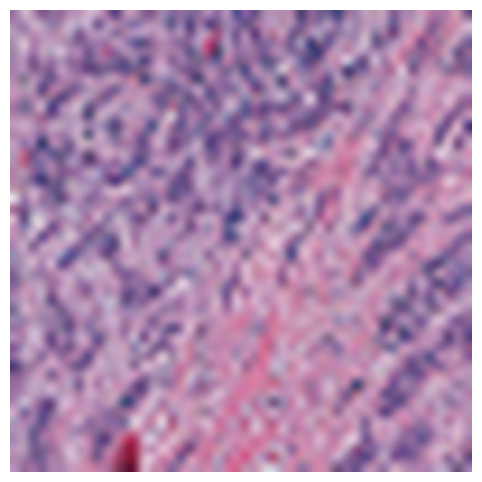

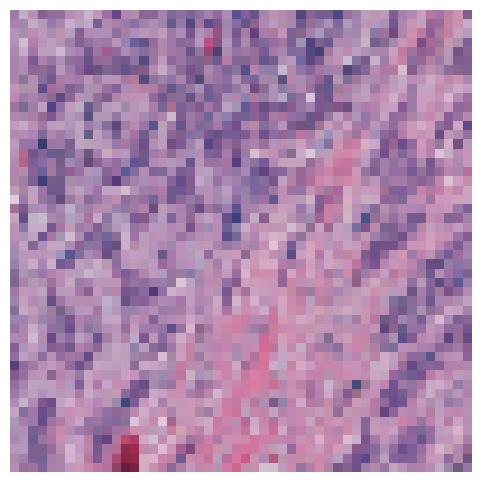

In [113]:
print(X_retrain.shape)

plt.figure(figsize = (8,6))
img_to_show = X_retrain[0]
plt.imshow(img_to_show)
plt.axis('off')  # 不显示坐标轴
plt.show

plt.figure(figsize = (8,6))
img_to_show = X_train1[0]
plt.imshow(img_to_show)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [122]:
# 加载不包含顶层的EfficientNet B1模型
base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240, 240, 3))


#冻结base_model参数
for layer in base_model.layers:
    layer.trainable = False

#添加输出层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
predictions = Dense(2, activation='softmax')(x)

model_Efficient = Model(inputs=base_model.input, outputs=predictions)

model_Efficient.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model_Efficient.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 120, 120, 32)         864       ['input_7[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 120, 120, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 120, 120, 32)         0         ['stem_bn[0][0]']       

In [123]:
checkpoint = ModelCheckpoint('best_efficient_model.h5',  
                             monitor='val_accuracy',  # 监测指标是验证集的准确率
                             verbose=1, 
                             save_best_only=True,  
                             mode='max')  # 模式为'max'因为监测的是准确率

In [ ]:
#%time history_2 = model_Efficient.fit(X_retrain, Y_train1, validation_data = (X_retest, Y_test1), epochs = 30, batch_size = 128,callbacks=[checkpoint])

Epoch 1/30


2024-01-25 06:09:27.041911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/35 [==============================] - ETA: 0s - loss: 0.8889 - accuracy: 0.4974
Epoch 1: val_accuracy improved from -inf to 0.48649, saving model to best_efficient_model.h5
35/35 [==============================] - 27s 473ms/step - loss: 0.8889 - accuracy: 0.4974 - val_loss: 0.7286 - val_accuracy: 0.4865
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.5094
Epoch 2: val_accuracy improved from 0.48649 to 0.49189, saving model to best_efficient_model.h5
35/35 [==============================] - 14s 407ms/step - loss: 0.7782 - accuracy: 0.5094 - val_loss: 0.7102 - val_accuracy: 0.4919
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.4947
Epoch 3: val_accuracy improved from 0.49189 to 0.49730, saving model to best_efficient_model.h5
35/35 [==============================] - 14s 407ms/step - loss: 0.7619 - accuracy: 0.4947 - val_loss: 0.7335 - val_accuracy: 0.4973
Epoch 4/30
35/35 [==============================

In [ ]:
# plt.plot(history_1.history['accuracy'])
# plt.plot(history_1.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# plt.plot(history_1.history['loss'])
# plt.plot(history_1.history['val_loss'])
# plt.title('Model Loss')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# Y_pred_inc = model_inception.predict(X_test)
# Y_pred_classes = np.argmax(Y_pred_inc,axis = 1) 
# Y_true = np.argmax(Y_test,axis = 1) 

# confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# f,ax = plt.subplots(figsize=(8,5))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()